In [1]:
from pathlib import Path

import numpy as np
from zanj import ZANJ

from maze_dataset import MazeDatasetConfig
from maze_dataset.generation import LatticeMazeGenerators
from maze_dataset.benchmark.percolation_fractions import (
    SweepResult,
    full_percolation_analysis,
    dataset_success_fraction,
    plot_grouped,
)

In [2]:
# magic auto-reload
%load_ext autoreload
%autoreload

tqdm_allowed_kwargs = {'lock_args', 'postfix', 'ascii', 'unit_divisor', 'nrows', 'leave', 'desc', 'gui', 'total', 'mininterval', 'initial', 'file', 'ncols', 'colour', 'maxinterval', 'smoothing', 'bar_format', 'write_bytes', 'self', 'miniters', 'disable', 'unit_scale', 'unit', 'dynamic_ncols', 'position', 'iterable', 'delay'}
mapped_kwargs = {'total': 3, 'desc': 'Processing 3 items'}


Processing 3 items: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


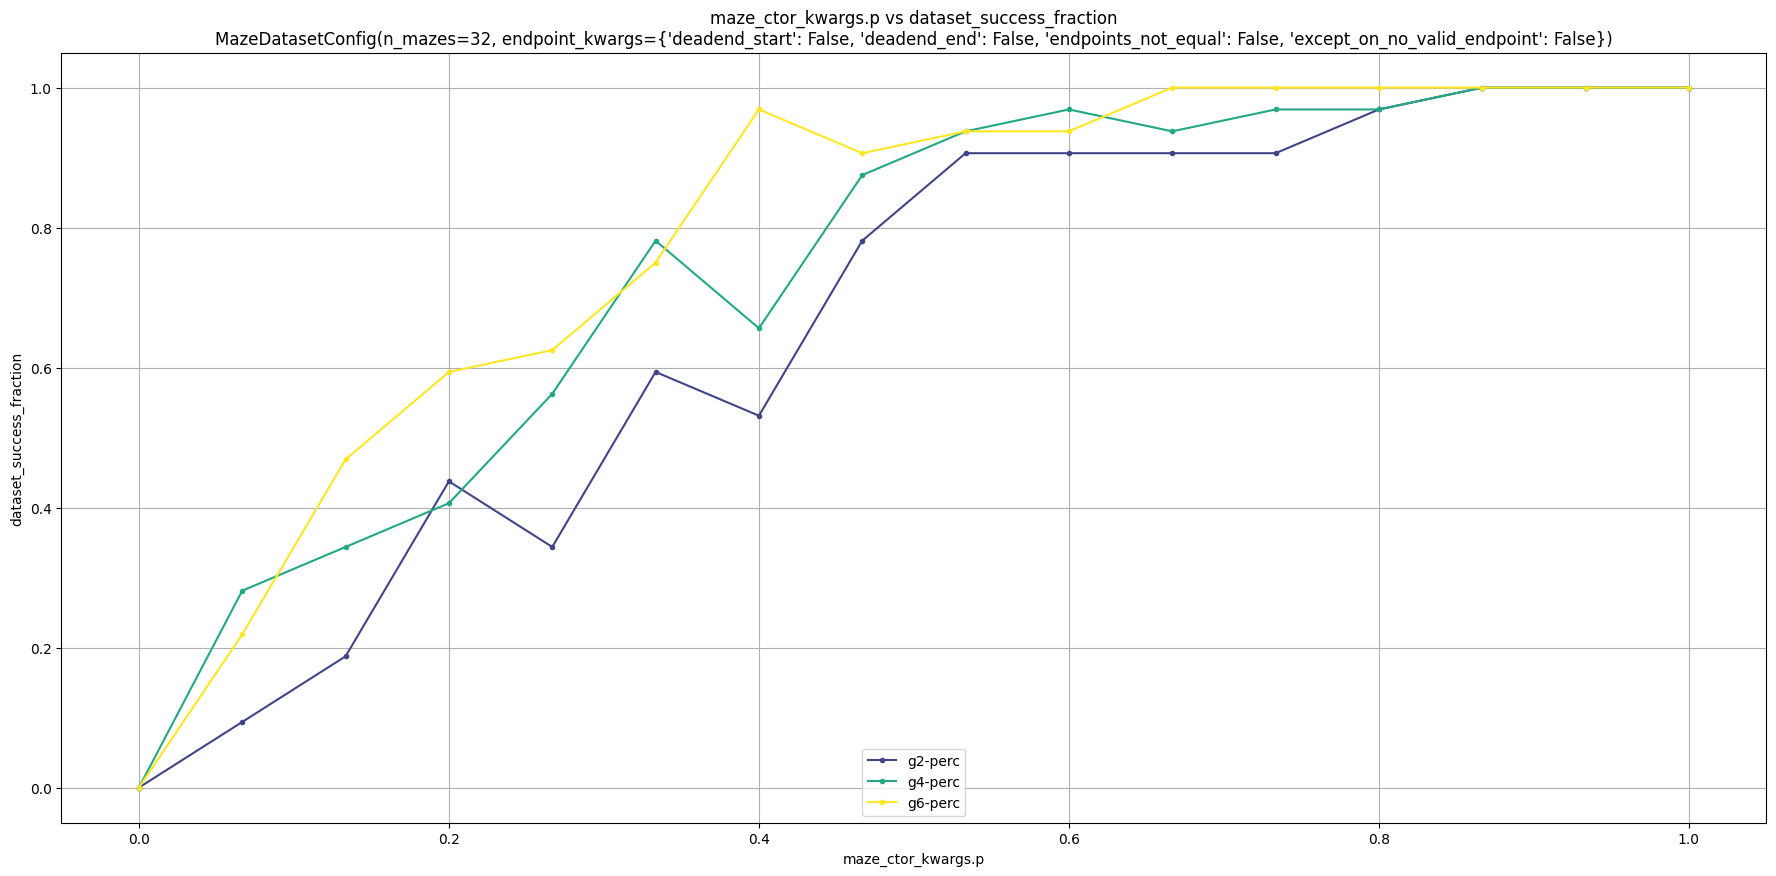

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [3]:
# Run the analysis
results: SweepResult = SweepResult.analyze(
    configs=[
        MazeDatasetConfig(
            name=f"g{grid_n}-perc",
            grid_n=grid_n,
            n_mazes=32,
            maze_ctor=LatticeMazeGenerators.gen_percolation,
            maze_ctor_kwargs=dict(),
            endpoint_kwargs=dict(
                deadend_start=False,
                deadend_end=False,
                endpoints_not_equal=False,
                except_on_no_valid_endpoint=False,
            ),
        )
        for grid_n in [2, 4, 6]
    ],
    param_values=np.linspace(0.0, 1.0, 16).tolist(),
    param_key="maze_ctor_kwargs.p",
    analyze_func=dataset_success_fraction,
    parallel=False,
)

# Plot results
results.plot(save_path=None, cfg_keys=["n_mazes", "endpoint_kwargs"])

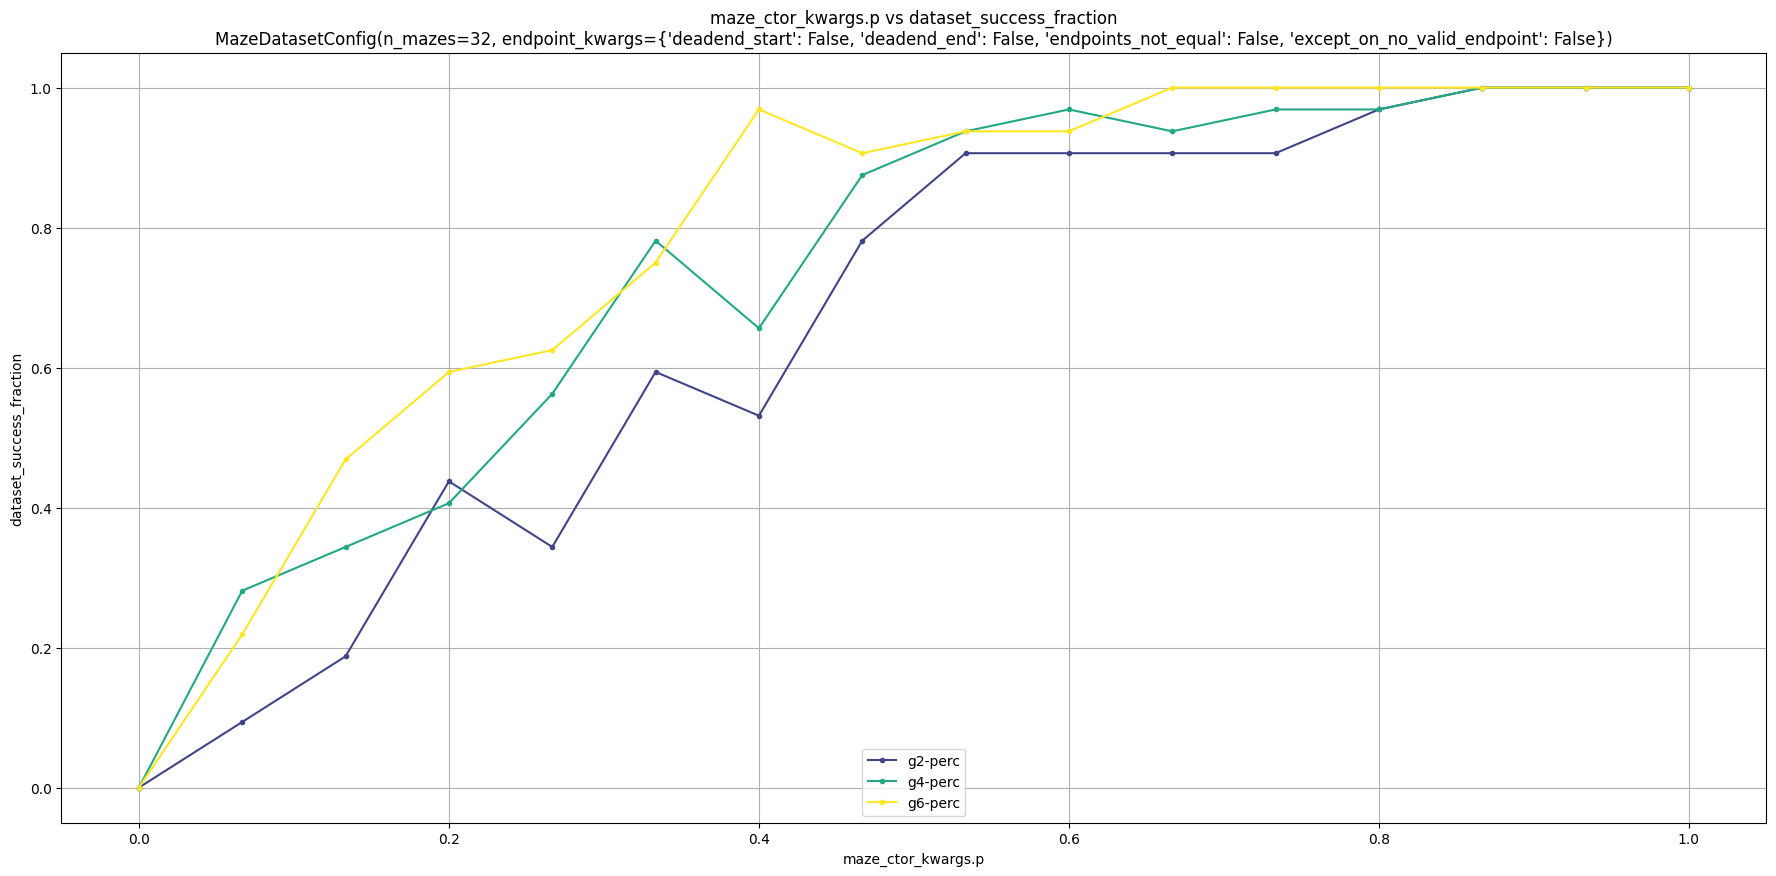

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [4]:
path = Path("../tests/_temp/dataset_frac_sweep/results_small.zanj")
results.save(path)
ZANJ().read(path).plot(cfg_keys=["n_mazes", "endpoint_kwargs"])

In [5]:
results_full: SweepResult = full_percolation_analysis(
    n_mazes=64,
    p_val_count=16,
    grid_sizes=[2, 4, 6],
    parallel=True,
)

tqdm_allowed_kwargs = {'lock_args', 'postfix', 'ascii', 'unit_divisor', 'nrows', 'leave', 'desc', 'gui', 'total', 'mininterval', 'initial', 'file', 'ncols', 'colour', 'maxinterval', 'smoothing', 'bar_format', 'write_bytes', 'self', 'miniters', 'disable', 'unit_scale', 'unit', 'dynamic_ncols', 'position', 'iterable', 'delay'}
mapped_kwargs = {'total': 18, 'desc': 'Processing 18 items'}


Processing 18 items: 100%|██████████| 18/18 [00:30<00:00,  1.68s/it]


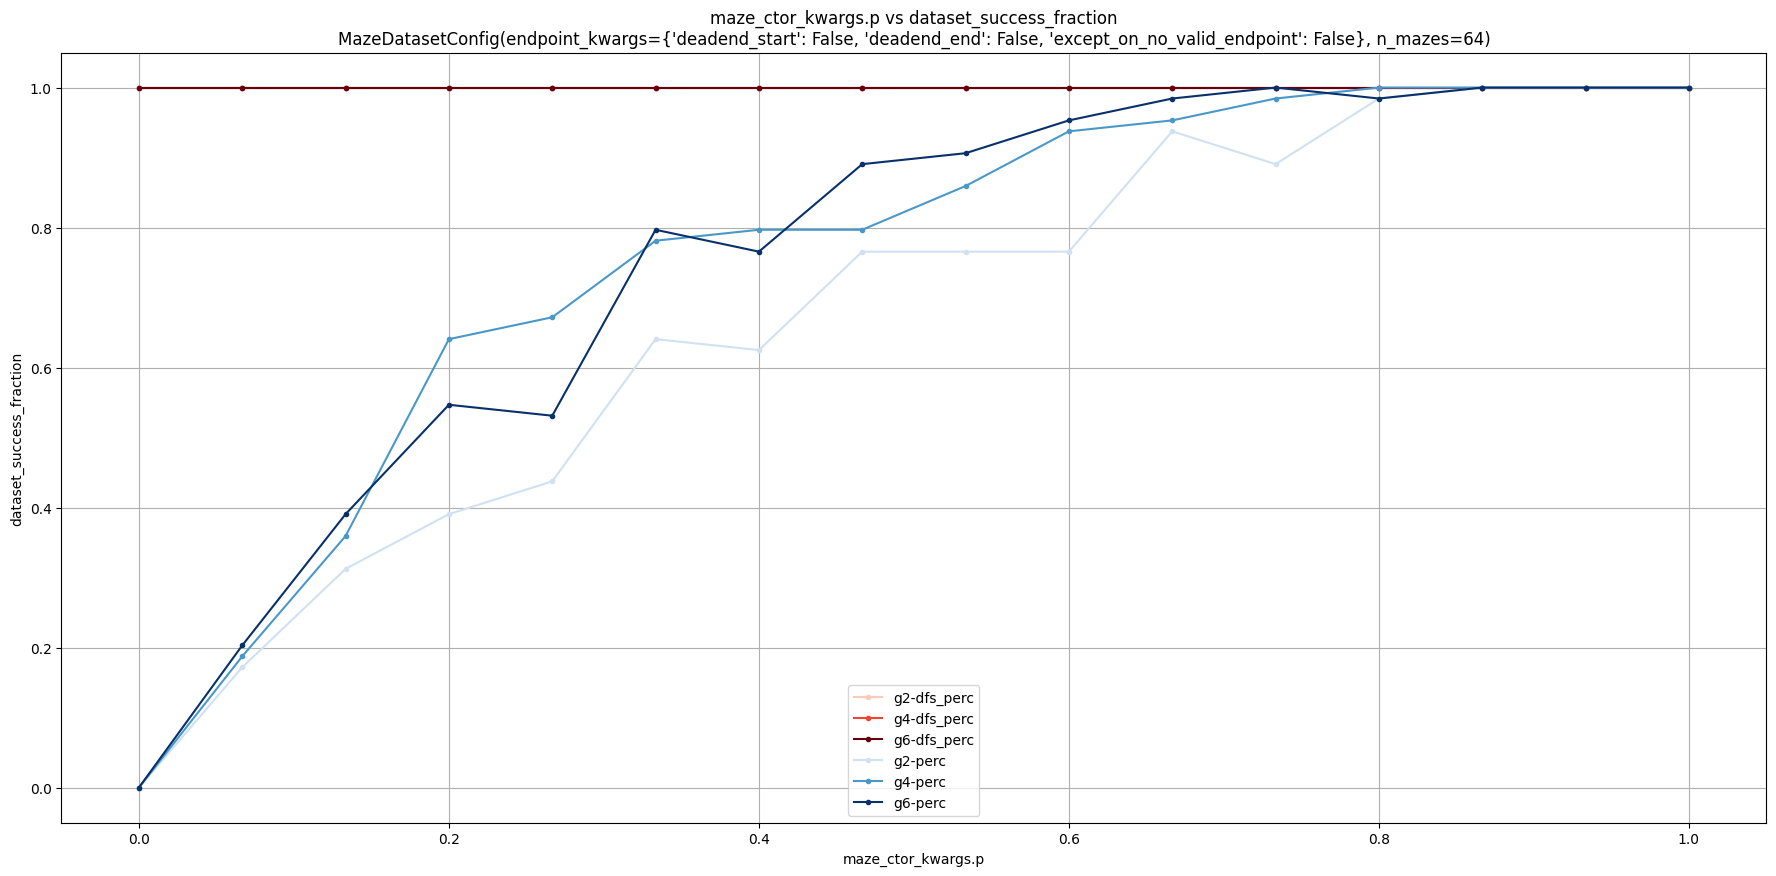

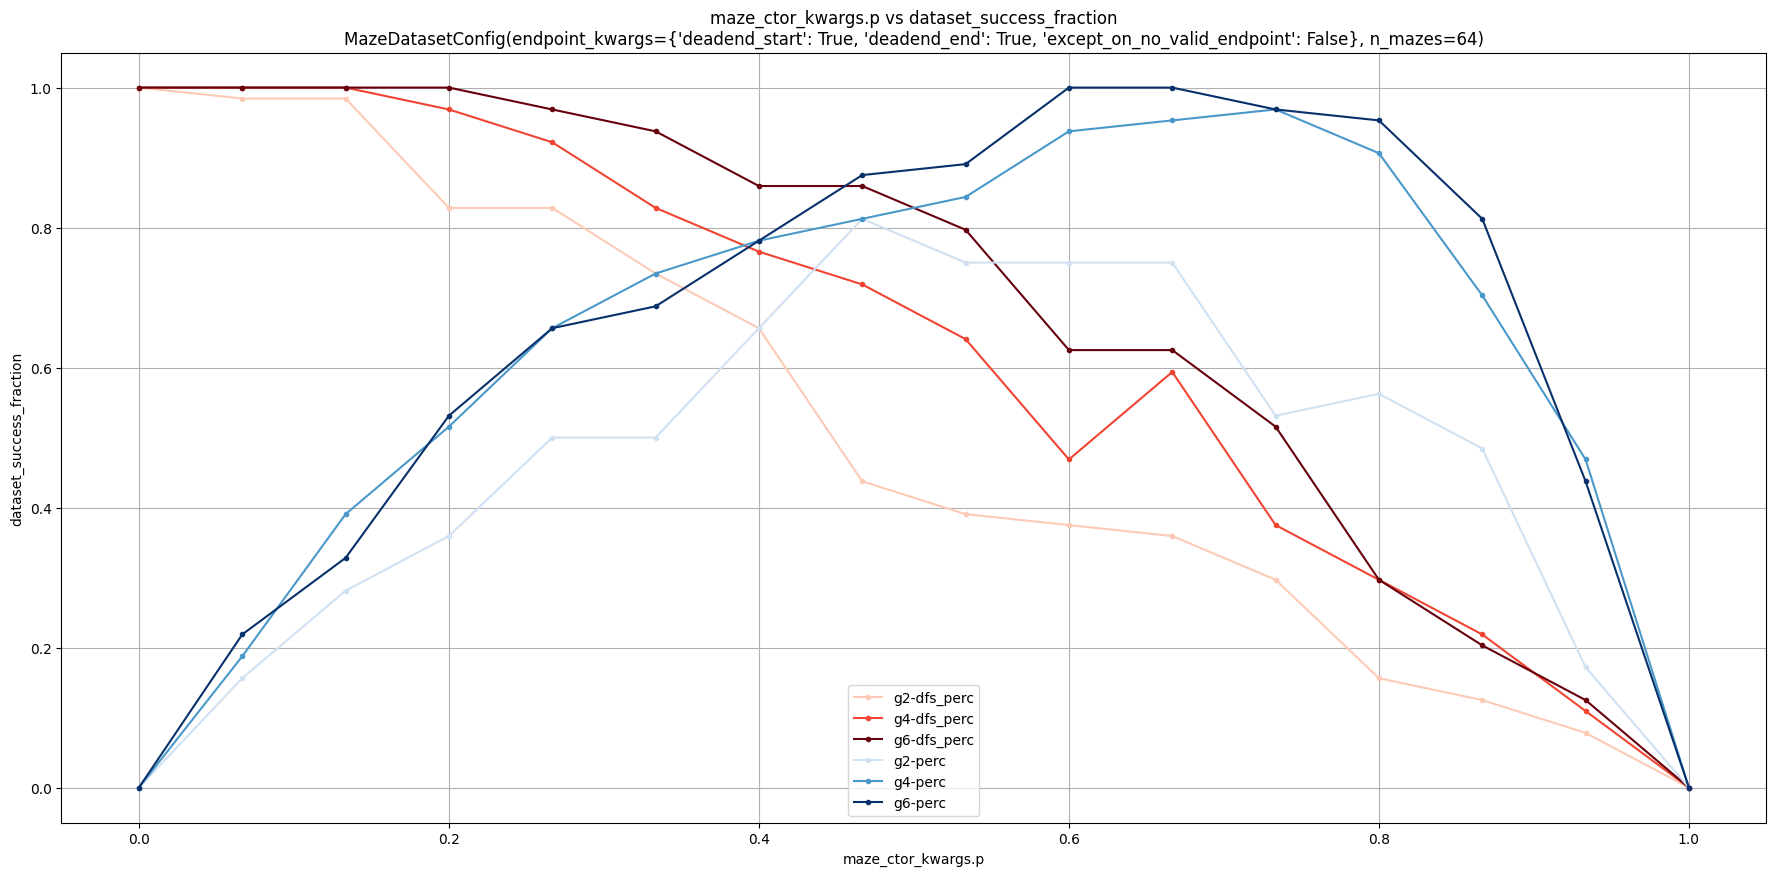

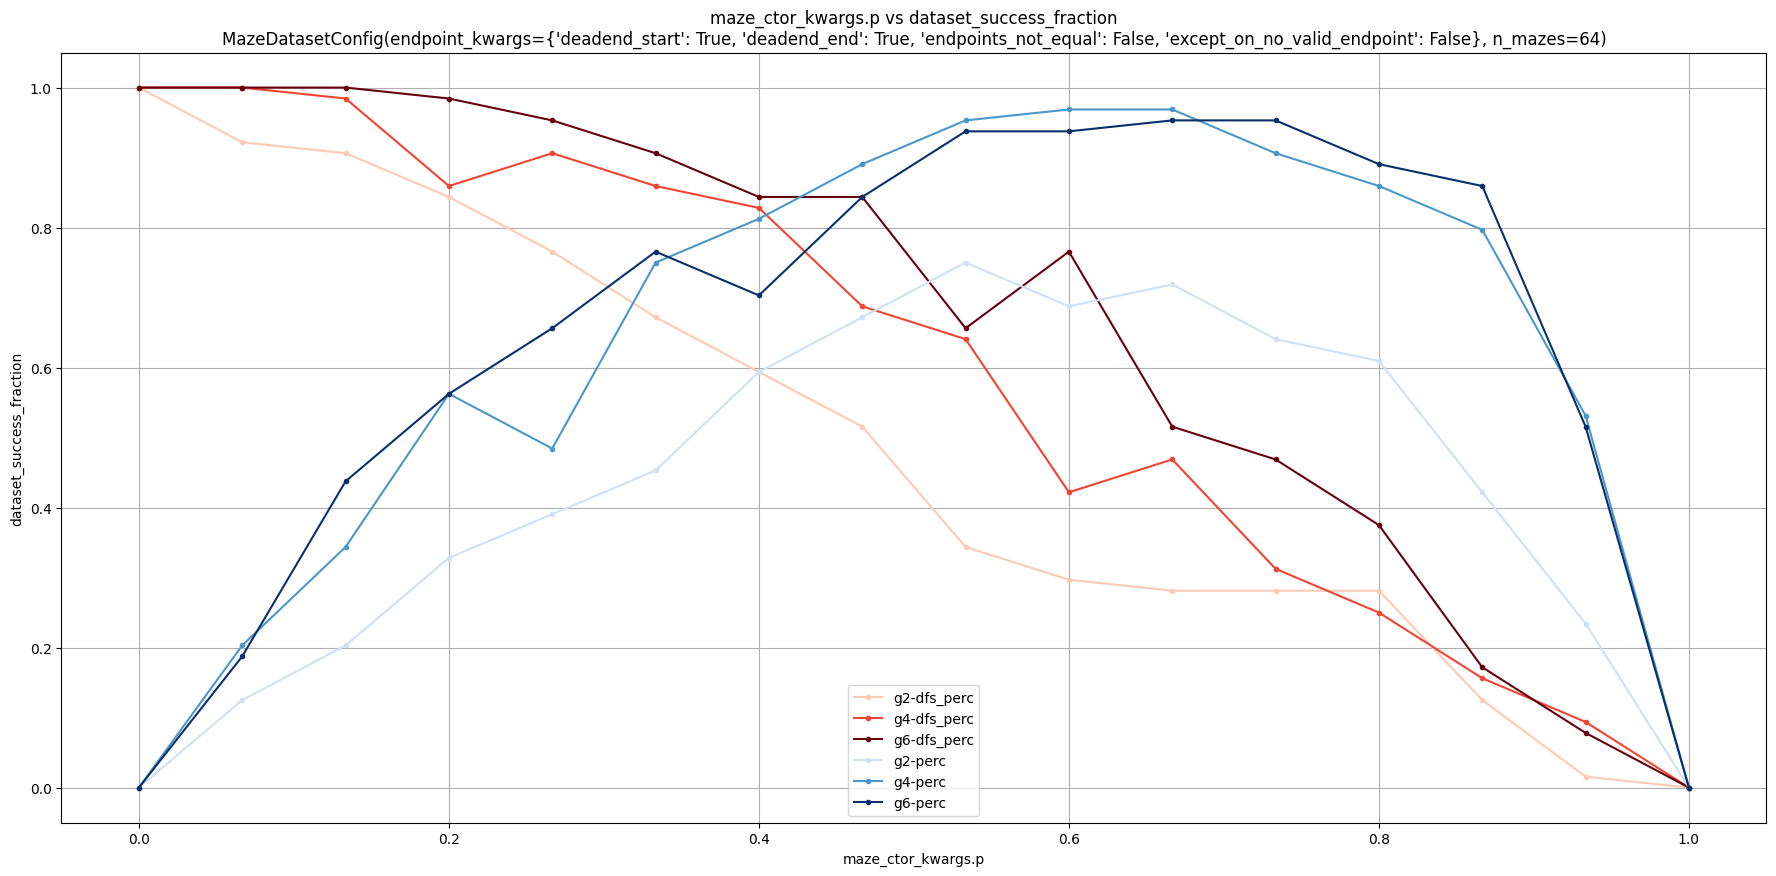

In [6]:
plot_grouped(results_full)